## iTransformer architecture
Sources:
- https://nixtlaverse.nixtla.io/neuralforecast/models.itransformer.html
- https://freedium.cfd/
- https://towardsdatascience.com/itransformer-the-latest-breakthrough-in-time-series-forecasting-d538ddc6c5d1
- https://claude.ai/chat/a026cdda-39bc-4f7f-b7f0-57e7f007ca06
- https://github.com/Nixtla/neuralforecast

In [18]:
Y_test_df

,unique_id,ds,y,trend,y_[lag12]
0,Airline1,1960-01-31,417.0,132,360.0
1,Airline1,1960-02-29,391.0,133,342.0
2,Airline1,1960-03-31,419.0,134,406.0
3,Airline1,1960-04-30,461.0,135,396.0
4,Airline1,1960-05-31,472.0,136,420.0
5,Airline1,1960-06-30,535.0,137,472.0
6,Airline1,1960-07-31,622.0,138,548.0
7,Airline1,1960-08-31,606.0,139,559.0
8,Airline1,1960-09-30,508.0,140,463.0
9,Airline1,1960-10-31,461.0,141,407.0


In [15]:
forecasts.shape

(24, 2)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | MSE                    | 0      | train
1 | valid_loss    | MAE                    | 0      | train
2 | padder        | ConstantPad1d          | 0      | train
3 | scaler        | TemporalNorm           | 0      | train
4 | enc_embedding | DataEmbedding_inverted | 3.2 K  | train
5 | encoder       | TransEncoder           | 135 K  | train
6 | projector     | Linear                 | 1.5 K  | train
-----------------------------------------------------------------
140 K     Trainable params
0         Non-trainable params
140 K     Total params
0.562     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 19.14it/s, v_num=4, train_loss_step=178.0, train_loss_epoch=178.0, valid_loss=18.40]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.48it/s]


/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


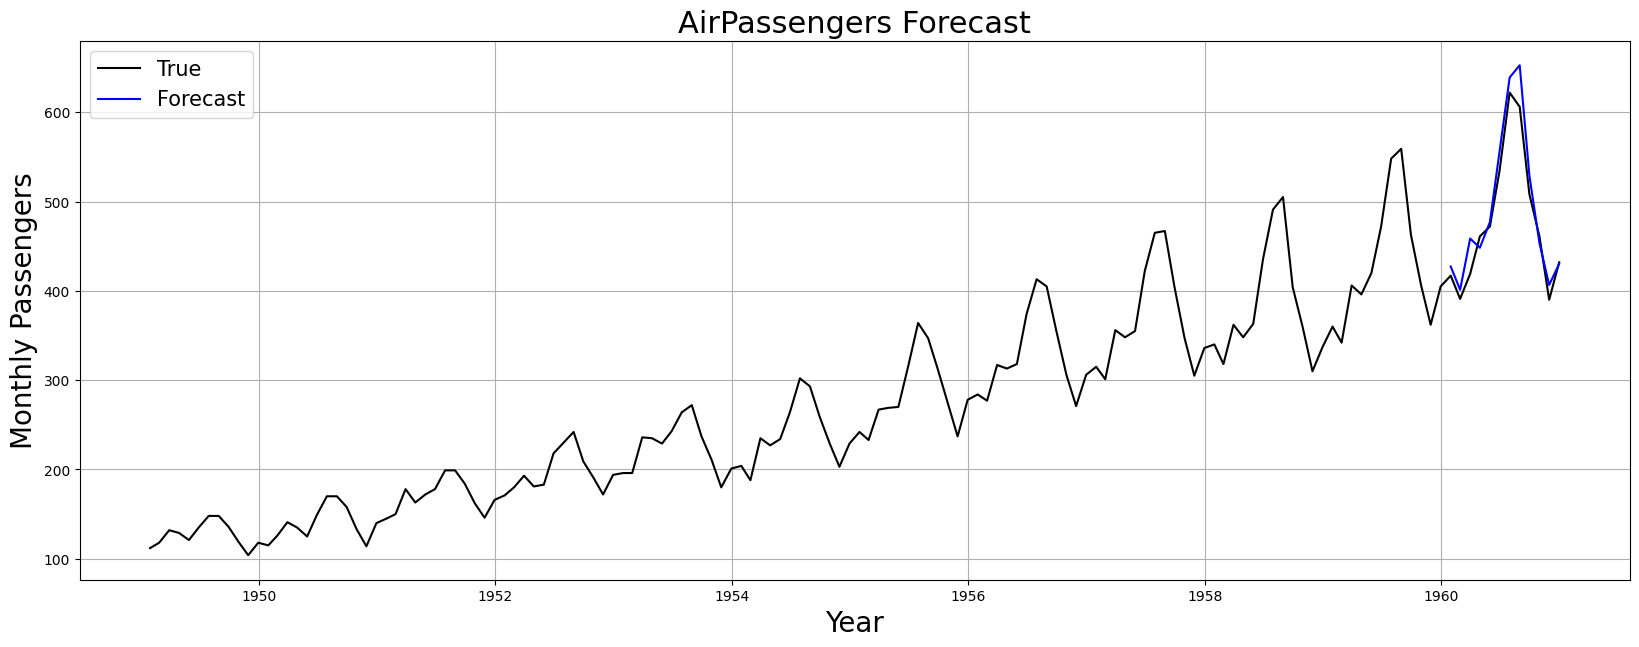

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import iTransformer
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.losses.pytorch import MSE, MAE

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = iTransformer(h=12,
                     input_size=24,
                     n_series=2,
                     hidden_size=128,
                     n_heads=2,
                     e_layers=2,
                     d_layers=1,
                     d_ff=4,
                     factor=1,
                     dropout=0.1,
                     use_norm=True,
                     loss=MSE(),
                     valid_loss=MAE(),
                     early_stop_patience_steps=3,
                     batch_size=32)

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['iTransformer'], c='blue', label='Forecast')
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
